<a href="https://colab.research.google.com/github/banned-books/project_banned_books/blob/main/appendix/LDA_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install pyLDAvis scattertext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Libraries

In [ ]:
# Import data cleaning libraries
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from pprint import pprint

# Import data visualization libraries
import scattertext as st
from wordcloud import WordCloud, STOPWORDS
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import seaborn as sns
%matplotlib inline

# Import NLP specific libraries
from gensim.corpora import Dictionary
from gensim import corpora, models
from gensim.test.utils import datapath
from gensim.models import LdaModel, Phrases, CoherenceModel, LdaMulticore
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

# Supress verbose warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import Cleaned Topic Modeling Data on Banned Books

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/data/cleaned_trained_data/clean_topic_modeling.pkl')
df.head(1)

,goodreads_image_url,title,author,goodreads_published_date,goodreads_description,goodreads_tags,type_of_ban,state,district,ban_date,...,goodreads_product_url,amazon_url,secondary_authors,illustrators,translators,text,Tokens,Joined_Tokens,top_10_words,parse
0,https://images-na.ssl-images-amazon.com/images...,The Haters,"Andrews, Jesse",2016-04-07,From Jesse Andrews author of the New York Tim...,"young adult, contemporary, music, fiction, rea...",Banned Pending Investigation,Michigan,Rochester Community Schools District,April 2022,...,https://www.goodreads.com/book/show/26095121-t...,https://www.amazon.com/Haters-Jesse-Andrews/pr...,NaN,NaN,NaN,"the haters young adult, contemporary, music, f...","[haters, young, adult, contemporary, music, fi...",haters young adult contemporary music fiction ...,"[haters, road, trip, music, humor, contemporar...","(haters, young, adult, contemporary, music, fi..."


## LDA Topic Modeling on Banned Books Metadata

### Create a Gensim corpus from a list of texts

In [ ]:
Texts = list(df['Tokens'])
dictionary = corpora.Dictionary(Texts)
corpus = [dictionary.doc2bow(text) for text in Texts]

### Calclulate the coherence values for a range of number of topics (part of tuning an LDA model)

In [ ]:
%%time
limit=20
start=2
step=2

NUM_TOPICS = 10
chunksize = 2000
passes = 8
iterations = 120
eval_every = 1
temp = dictionary[0]
id2word = dictionary.id2token
rand_state = 42

def compute_coherence_values(dictionary, corpus, texts, cohere, limit, start=2, step=2):
    '''Return the LDA coherence values.'''

    coherence_values = []

    for num_topics in range(start, limit, step):
        
        model = LdaModel(corpus=corpus, 
                         id2word=dictionary, 
                         num_topics=num_topics,
                         chunksize=chunksize,
                         alpha='auto',
                         eta='auto',
                         iterations=iterations,
                         passes=passes,
                         random_state=rand_state,)
        
        coherencemodel = CoherenceModel(model=model, 
                                        texts=texts, 
                                        dictionary=dictionary, 
                                        coherence=cohere)
        
        coherence_values.append(coherencemodel.get_coherence())

    return coherence_values

coherence_values = compute_coherence_values(dictionary=dictionary, 
                                            corpus=corpus, 
                                            texts=Texts, 
                                            cohere='c_v', 
                                            start=start, 
                                            limit=limit, 
                                            step=step)

CPU times: user 1min 10s, sys: 7.78 s, total: 1min 17s
Wall time: 1min 13s


In [ ]:
coherence_values

[0.40409782928544813,
 0.5057976058318581,
 0.43042699501679565,
 0.4403944786563968,
 0.434126646281752,
 0.45528851185319713,
 0.44044085891058893,
 0.4501000772986157,
 0.4533811443525367]

### Plot the coherence values and pick the best number of topics for the LDA model

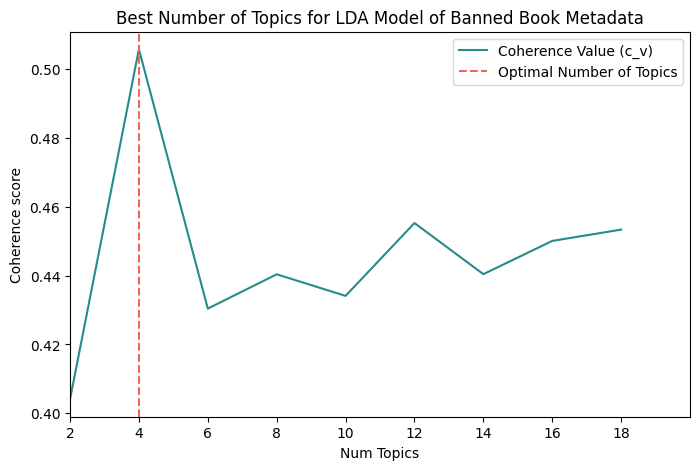

In [ ]:
plt.figure(figsize=(8,5))

# Create a custom x-axis
x = range(start, limit, step)

# Build the line plot
ax = sns.lineplot(x=x, y=coherence_values, color='#238C8C')

# Set titles and labels
plt.title("Best Number of Topics for LDA Model of Banned Book Metadata")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xlim(start, limit)
plt.xticks(range(2, limit, step))

# Add a vertical line to show the optimum number of topics
plt.axvline(x[np.argmax(coherence_values)], 
            color='#F26457', linestyle='--')

# Draw a custom legend
legend_elements = [Line2D([0], [0], color='#238C8C', 
                          ls='-', label='Coherence Value (c_v)'),
                   Line2D([0], [1], color='#F26457', 
                          ls='--', label='Optimal Number of Topics')]

ax.legend(handles=legend_elements, loc='upper right')

plt.show();

### Train the LDA Model and Visualize in pyLDAvis on the Best Number of Topics

In [ ]:
lda_sym = models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=4,
    update_every=1,
    chunksize=100000,
    passes=100,
    alpha="auto",
    eta="auto",
)

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_sym, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.236891  0.130458       1        1  49.252634
0     -0.118561 -0.177689       2        1  20.058350
1      0.173511 -0.147534       3        1  18.170423
3      0.181942  0.194765       4        1  12.518593, topic_info=             Term         Freq        Total Category  logprob  loglift
2         fiction  3226.000000  3226.000000  Default  30.0000  30.0000
10          young  1791.000000  1791.000000  Default  29.0000  29.0000
0           adult  2064.000000  2064.000000  Default  28.0000  28.0000
1    contemporary  1410.000000  1410.000000  Default  27.0000  27.0000
16        graphic   331.000000   331.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
86         middle    34.589560   330.997170   Topic4  -4.9558  -0.1806
40       feminism    24.581772   118.713692   Topic4  -5.2974   0.5032
157       history    24.877812   265.208894   Topic4  -5.2854  -0.2886
56         family    18.974072   435.954169   Topic4  -5.5563  -1.0565
0           adult    20.066906  2064.619500   Topic4  -5.5003  -2.5557

[258 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
255       1  0.977326  absolutely
154       1  0.995450       abuse
232       3  0.992489    activism
0         1  0.940125       adult
0         2  0.049888       adult
...     ...       ...         ...
134       3  0.863661      womens
134       4  0.061690      womens
2690      2  0.946434      yasmin
10        1  0.976279       young
10        2  0.023444       young

[298 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4])

### Show the Model's Final Perplexity and Coherence Scores

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_sym.log_perplexity(corpus)) 


Perplexity:  -4.991621921536298


In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_sym, corpus=corpus, texts=Texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ',  coherence_lda)


Coherence Score:  0.48111732189794154




---





# LDA Topic Modeling on Amazon Reviews

## Pre-process Amazon Reviews for LDA Topic Model

In [ ]:
stoplist = [
            'the', 'a', 'an', 'of', 'and', 'or', 'in', 'for', 'to', 'at', 'by', 'from', 'with', 'on', 'as', 'but', 'is', 'are', 'was', 'were', 'be', 'been', 'am', 'i', 'me', 'my', 'we', 'our', 'you', 'fish', 'ha', 'bye', 'okay', 'andy', 'wa', 'nt',
            "a","able","about","above","abst","accordance","according","accordingly","across","act","actually","added","adj","affected","affecting","affects","after","afterwards","again","against","ah","all","almost","alone","along","already","also","although","always","am","among","amongst","an","and","announce","another","any","anybody","anyhow","anymore","anyone","anything","anyway","anyways","anywhere","apparently","approximately","are","aren","arent","arise","around","as","aside","ask","asking","at","auth","available","away","awfully","b","back","be","became","because","become","becomes","becoming","been","before","beforehand","begin","beginning","beginnings","begins","behind","being","believe","below","beside","besides","between","beyond","biol","both","brief","briefly","but","by","c","ca","came","can","cannot","can't","cause","causes","certain","certainly","co","com","come","comes","contain","containing","contains","could","couldnt","d","date","did","didn't","different","do","does","doesn't","doing","done","don't","down","downwards","due","during","e","each","ed","edu","effect","eg","eight","eighty","either","else","elsewhere","end","ending","enough","especially","et","et-al","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","except","f","far","few","ff","fifth","first","five","fix","followed","following","follows","for","former","formerly","forth","found","four","from","further","furthermore","g","gave","get","gets","getting","give","given","gives","giving","go","goes","gone","got","gotten","h","had","happens","hardly","has","hasn't","have","haven't","having","he","hed","hence","her","here","hereafter","hereby","herein","heres","hereupon","hers","herself","hes","hi","hid","him","himself","his","hither","home","how","howbeit","however","hundred","i","id","ie","if","i'll","im","immediate","immediately","importance","important","in","inc","indeed","index","information","instead","into","invention","inward","is","isn't","it","itd","it'll","its","itself","i've","j","just","k","keep",	"keeps","kept","kg","km","know","known","knows","l","largely","last","lately","later","latter","latterly","least","less","lest","let","lets","like","liked","likely","line","little","'ll","look","looking","looks","ltd","m","made","mainly","make","makes","many","may","maybe","me","mean","means","meantime","meanwhile","merely","mg","might","million","miss","ml","more","moreover","most","mostly","mr","mrs","much","mug","must","my","myself","n","na","name","namely","nay","nd","near","nearly","necessarily","necessary","need","needs","neither","never","nevertheless","new","next","nine","ninety","no","nobody","non","none","nonetheless","noone","nor","normally","nos","not","noted","nothing","now","nowhere","o","obtain","obtained","obviously","of","off","often","oh","ok","okay","old","omitted","on","once","one","ones","only","onto","or","ord","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","owing","own","p","page","pages","part","particular","particularly","past","per","perhaps","placed","please","plus","poorly","possible","possibly","potentially","pp","predominantly","present","previously","primarily","probably","promptly","proud","provides","put","q","que","quickly","quite","qv","r","ran","rather","rd","re","readily","really","recent","recently","ref","refs","regarding","regardless","regards","related","relatively","research","respectively","resulted","resulting","results","right","run","s","said","same","saw","say","saying","says","sec","section","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sent","seven","several","shall","she","shed","she'll","shes","should","shouldn't","show","showed","shown","showns","shows","significant","significantly",
            "similar","similarly","since","six","slightly","so","some","somebody","somehow","someone","somethan","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specifically","specified","specify","specifying","still","stop","strongly","sub","substantially","successfully","such","sufficiently","suggest","sup","sure",	"t","take","taken","taking","tell","tends","th","than","thank","thanks","thanx","that","that'll","thats","that've","the","their","theirs","them","themselves","then","thence","there","thereafter","thereby","thered","therefore","therein","there'll","thereof","therere","theres","thereto","thereupon","there've","these","they","theyd","they'll","theyre","they've","think","this","those","thou","though","thoughh","thousand","throug","through","throughout","thru","thus","til","tip","to","together","too","took","toward","towards","chapter", 'condition', 'la',"tried","tries","truly","try","trying","ts","twice","two","u","un","under","unfortunately","unless","unlike","unlikely","until","unto","up","upon","ups","us","use","used","useful","usefully","usefulness","uses","using","usually","v","value","various","'ve","very","via","viz","vol","vols","vs","w","want","wants","was","wasnt","way","we","wed","welcome","we'll","went","were","werent","we've","what","whatever","what'll","whats","when","whence","whenever","where","whereafter","whereas","whereby","wherein","wheres","whereupon","wherever","whether","which","while","whim","whither","who","whod","whoever","whole","who'll","whom","whomever","whos","whose","why","widely","willing","wish","with","within","without","wont","words","world","would","wouldnt","www","x","y","yes","yet","you","youd","you'll","your","youre","yours","yourself","yourselves","you've","z","zero", "wa", "nt", "ha", "purchased", "ordered", "amazon", "damaged", 
            "book","read","character","story","will","school","student", "people", "parent", "child", "weekend", "people", "person", "well", "doe", "feel", "felt", "cover", "arrived", "described", "addie",
            "não", "write", "writing", "episode", "website", "robin", "kosawa", "emily", "judy", "buch", "gline", "griffin", "patrick", "feyre", "nesta", "de", "purchase",
            "cliff", "carter", "novel", "caroline", "ii", "molly", "aside", "arthur", "academy", "cad", "season", "jennifer", "simon", 'lot', 'ya', "atwood", 'author',
            "reader", "buy", "copy", "morrison", "story", "storytelling", "reading", "series", "absolutely", "definitely", "go", "going", "bought", "written", "review",          
            "book","read","character","story","will", "weekend", "find", "main", "people", "person", "well", "felt", "feel", "scene",
            "não", "write", "writing", "episode", "website", "robin", "kosawa", "emily", "judy", "buch", "gline", "griffin", "patrick", "baz", "lerue", "henry", 
            "cliff", "carter", "novel", "caroline", "ii", "molly", "aside", "arthur", "academy", "cad", "season", "jennifer", "atwood", 'author', "things", "thing", "thought", "wanted", "bit",
            "reader", "buy", "copy", "morrison", "story", "storytelling", "reading", "series", "plot", "audiobook", "narrator", "topic", "addie"
           ]

# Bring in ALA dataset 
banned_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/original_data/pen_dataset.csv')

# Remove duplicate books for web scraper
banned_df = banned_df.drop_duplicates(subset=['amazon_url'])

# Drop lines where author is duplicated
banned_df = banned_df.drop_duplicates(subset=['Author'])

# Remove books without Amazon reviews
banned_df = banned_df.dropna(subset=['amazon_url'])

# Create list of authors to add to stop words
author_list = [val.strip() for sublist in banned_df.Author.dropna().str.split(",").tolist() for val in sublist]
author_list = list(set(author_list))
author_list = author_list[1:]
author_list = [i.lower() for i in author_list]

# Add author names to domain specific stop words
stoplist.extend(author_list)

# Add standard English stopwords
stop = stopwords.words('english')
stoplist.extend(stop)



---



---



## LDA Topic Modeling One Year **Before** the First Book Ban (Amazon Reviews)

### Bring in the Data

In [ ]:
before_ban_df = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/data/cleaned_trained_data/before_ban_amazon_review_data.pkl")
documents = before_ban_df['pre_process'].to_list()

### Pre-process the Text

In [ ]:
# remove common words and tokenize
texts = [[word for word in document.split() if word not in stoplist]
         for document in documents]

# remove words that appear only once
frequency = defaultdict(int)

for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 5]
         for text in texts]

# Add bigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(texts, min_count=20)

for idx in range(len(texts)):
    for token in bigram[texts[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            texts[idx].append(token)

# Create the dictionary
dictionary = corpora.Dictionary(texts)

# Filter out words that occur less than X documents.
dictionary.filter_extremes(no_below=50, no_above=0.5)

# Create the corpus.  This is a Term Frequency / Bag of Words appraoch.
corpus = [dictionary.doc2bow(text) for text in texts]

print(f'Number of unique tokens: {len(dictionary)}')
print(f'Number of documents: {len(corpus)}')

Number of unique tokens: 3041
Number of documents: 37492


### Run Experiments to Tune the LDA Model and Pick the Best Parameters

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

In [ ]:
NUM_TOPICS = 10
chunksize = 2000
passes = 8
iterations = 120
eval_every = 1
temp = dictionary[0]
id2word = dictionary.id2token
rand_state = 42

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every,
    random_state=rand_state
)

### Calculate the Coherence Scores and Optimal Number of Topics

In [ ]:
%%time

limit=10
start=2
step=2

def compute_coherence_values(dictionary, corpus, texts, cohere, limit, start=2, step=2):
    '''Return the LDA coherence value.'''

    coherence_values = []

    for num_topics in range(start, limit, step):
        
        model = LdaModel(corpus=corpus, 
                         id2word=dictionary, 
                         num_topics=num_topics,
                         chunksize=chunksize,
                         alpha='auto',
                         eta='auto',
                         iterations=iterations,
                         passes=passes,
                         random_state=rand_state,)
        
        coherencemodel = CoherenceModel(model=model, 
                                        texts=texts, 
                                        dictionary=dictionary, 
                                        coherence=cohere)
        
        coherence_values.append(coherencemodel.get_coherence())

    return coherence_values


coherence_values = compute_coherence_values(dictionary=dictionary, 
                                            corpus=corpus, 
                                            texts=texts, 
                                            cohere='c_v', 
                                            start=start, 
                                            limit=limit, 
                                            step=step)

CPU times: user 5min 58s, sys: 16.6 s, total: 6min 15s
Wall time: 6min 1s


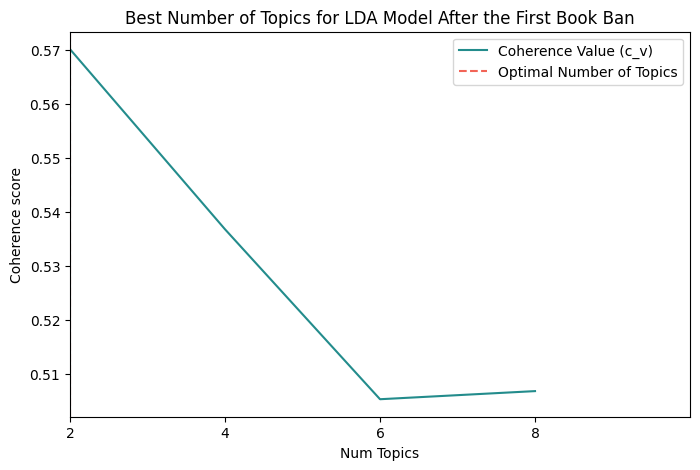

In [ ]:
plt.figure(figsize=(8,5))

# Create a custom x-axis
x = range(start, limit, step)

# Build the line plot
ax = sns.lineplot(x=x, y=coherence_values, color='#238C8C')

# Set titles and labels
plt.title("Best Number of Topics for LDA Model After the First Book Ban")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xlim(start, limit)
plt.xticks(range(2, limit, step))

# Add a vertical line to show the optimum number of topics
plt.axvline(x[np.argmax(coherence_values)], 
            color='#F26457', linestyle='--')

# Draw a custom legend
legend_elements = [Line2D([0], [0], color='#238C8C', 
                          ls='-', label='Coherence Value (c_v)'),
                   Line2D([0], [1], color='#F26457', 
                          ls='--', label='Optimal Number of Topics')]

ax.legend(handles=legend_elements, loc='upper right')

plt.show();

### Build the Best Model

In [ ]:
temp = dictionary[0]
id2word = dictionary.id2token

lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=2000,
    alpha='auto',
    eta='auto',
    iterations=120,
    num_topics=2,
    passes=8,
    eval_every=None
)

### Visualize the Best Model with pyLDAvis, Word Topic Scores, and a Word Cloud

#### pyLDAvis

In [ ]:
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=True)

pyLDAvis.display(lda_viz)

#### Print Topics

In [ ]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.019*"great" + 0.014*"good" + 0.013*"loved" + 0.013*"characters" + '
  '0.011*"books" + 0.009*"time" + 0.009*"life" + 0.008*"amazing" + '
  '0.007*"beautiful" + 0.007*"family"'),
 (1,
  '0.029*"caste" + 0.014*"history" + 0.013*"black" + 0.012*"system" + '
  '0.011*"racism" + 0.011*"america" + 0.010*"american" + 0.009*"race" + '
  '0.008*"caste_system" + 0.006*"country"')]


#### Word Cloud

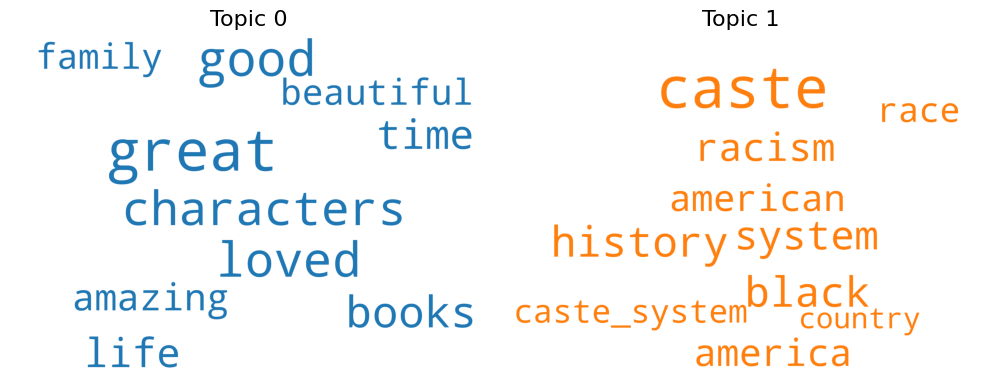

In [ ]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stoplist,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#### Word Score Bar Graph (with Word Count)

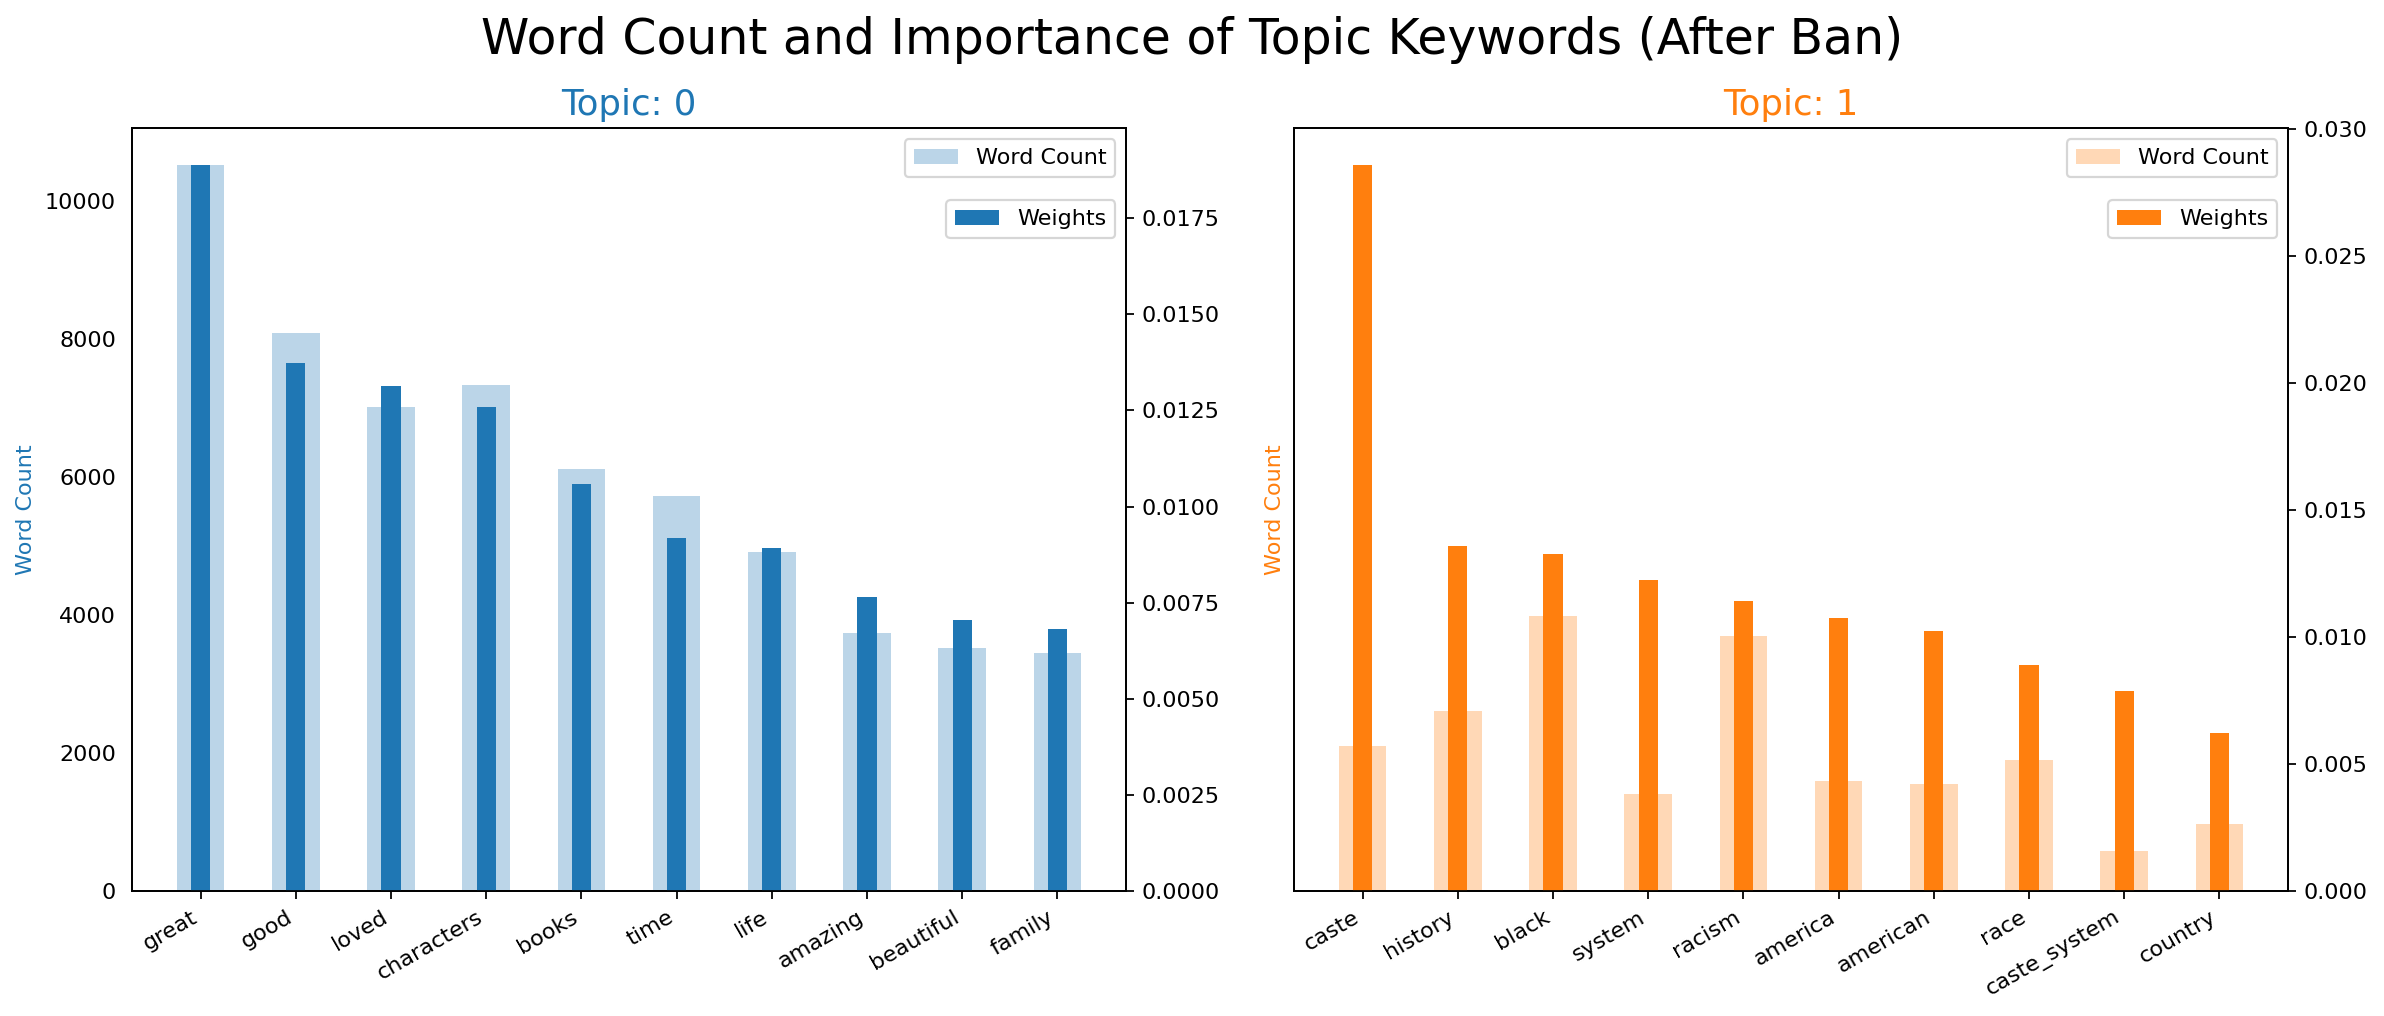

In [ ]:
topics = lda_model.show_topics(formatted=False)

data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(1, 2, figsize=(15,6), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, None); ax.set_ylim(0, None)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper right'); ax_twin.legend(bbox_to_anchor=(1.0, .92))

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords (After Ban)', fontsize=22, y=1.05)    
plt.show()

### Show the Model's Final Perplexity and Coherence Scores

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 


Perplexity:  -7.293462426402755


In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, corpus=corpus, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ',  coherence_lda)


Coherence Score:  0.5609745150345868


## LDA Topic Modeling One Year **After** the First Book Ban (Amazon Reviews)

### Bring in the Data

In [ ]:
after_ban_df = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/data/cleaned_trained_data/after_ban_amazon_review_data.pkl")
documents = after_ban_df['pre_process'].to_list()

### Pre-process the Text

In [ ]:
# remove common words and tokenize
texts = [[word for word in document.split() if word not in stoplist]
         for document in documents]

# remove words that appear only once
frequency = defaultdict(int)

for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 5]
         for text in texts]

# Add bigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(texts, min_count=20)

for idx in range(len(texts)):
    for token in bigram[texts[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            texts[idx].append(token)

# Create the dictionary
dictionary = corpora.Dictionary(texts)

# Filter out words that occur less than X documents.
dictionary.filter_extremes(no_below=50, no_above=0.5)

# Create the corpus.  This is a Term Frequency / Bag of Words appraoch.
corpus = [dictionary.doc2bow(text) for text in texts]

print(f'Number of unique tokens: {len(dictionary)}')
print(f'Number of documents: {len(corpus)}')

Number of unique tokens: 1847
Number of documents: 24780


### Run Experiments to Tune the LDA Model and Pick the Best Parameters

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

In [ ]:
NUM_TOPICS = 10
chunksize = 2000
passes = 8
iterations = 120
eval_every = 1
temp = dictionary[0]
id2word = dictionary.id2token
rand_state = 42

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every,
    random_state=rand_state
)

### Calculate the Coherence Scores and Optimal Number of Topics

In [ ]:
%%time

limit=10
start=2
step=2

def compute_coherence_values(dictionary, corpus, texts, cohere, limit, start=2, step=2):
    '''Return the LDA coherence value.'''

    coherence_values = []

    for num_topics in range(start, limit, step):
        
        model = LdaModel(corpus=corpus, 
                         id2word=dictionary, 
                         num_topics=num_topics,
                         chunksize=chunksize,
                         alpha='auto',
                         eta='auto',
                         iterations=iterations,
                         passes=passes,
                         random_state=rand_state,)
        
        coherencemodel = CoherenceModel(model=model, 
                                        texts=texts, 
                                        dictionary=dictionary, 
                                        coherence=cohere)
        
        coherence_values.append(coherencemodel.get_coherence())

    return coherence_values


coherence_values = compute_coherence_values(dictionary=dictionary, 
                                            corpus=corpus, 
                                            texts=texts, 
                                            cohere='c_v', 
                                            start=start, 
                                            limit=limit, 
                                            step=step)

CPU times: user 3min 57s, sys: 13.2 s, total: 4min 10s
Wall time: 3min 59s


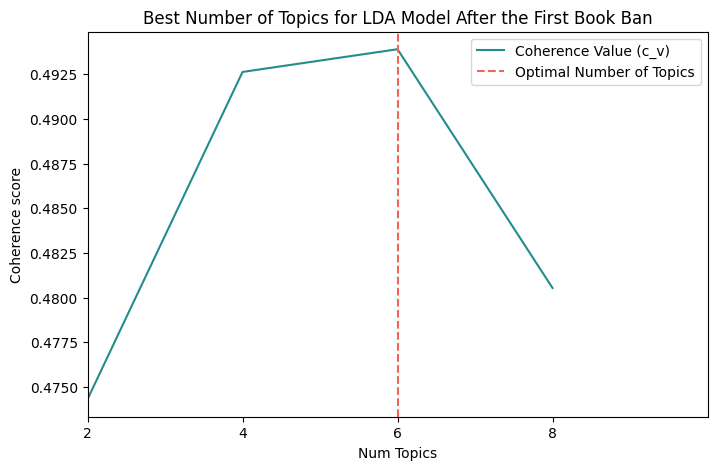

In [ ]:
plt.figure(figsize=(8,5))

# Create a custom x-axis
x = range(start, limit, step)

# Build the line plot
ax = sns.lineplot(x=x, y=coherence_values, color='#238C8C')

# Set titles and labels
plt.title("Best Number of Topics for LDA Model After the First Book Ban")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xlim(start, limit)
plt.xticks(range(2, limit, step))

# Add a vertical line to show the optimum number of topics
plt.axvline(x[np.argmax(coherence_values)], 
            color='#F26457', linestyle='--')

# Draw a custom legend
legend_elements = [Line2D([0], [0], color='#238C8C', 
                          ls='-', label='Coherence Value (c_v)'),
                   Line2D([0], [1], color='#F26457', 
                          ls='--', label='Optimal Number of Topics')]

ax.legend(handles=legend_elements, loc='upper right')

plt.show();

### Build the best model

In [ ]:
temp = dictionary[0]
id2word = dictionary.id2token

lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=2000,
    alpha='auto',
    eta='auto',
    iterations=120,
    num_topics=6,
    passes=8,
    eval_every=None
)

### Visualize the Best Model with pyLDAvis, Word Topic Scores, and a Word Cloud

#### pyLDAvis

In [ ]:
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=True)

pyLDAvis.display(lda_viz)

#### Print Topics

In [ ]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.040*"life" + 0.014*"years" + 0.013*"family" + 0.009*"live" + 0.008*"man" '
  '+ 0.007*"real" + 0.007*"hope" + 0.007*"experience" + 0.007*"true" + '
  '0.006*"human"'),
 (1,
  '0.143*"great" + 0.070*"good" + 0.024*"books" + 0.023*"daughter" + '
  '0.023*"kids" + 0.022*"year" + 0.018*"excellent" + 0.016*"perfect" + '
  '0.014*"loved" + 0.013*"beautiful"'),
 (2,
  '0.021*"young" + 0.014*"girl" + 0.013*"friends" + 0.012*"family" + '
  '0.011*"relationship" + 0.011*"age" + 0.010*"cute" + 0.009*"adult" + '
  '0.009*"high" + 0.009*"parents"'),
 (3,
  '0.029*"time" + 0.024*"good" + 0.023*"characters" + 0.017*"interesting" + '
  '0.013*"books" + 0.011*"long" + 0.010*"enjoyed" + 0.010*"better" + '
  '0.009*"hard" + 0.008*"stars"'),
 (4,
  '0.037*"caste" + 0.022*"children" + 0.020*"history" + 0.018*"racism" + '
  '0.017*"system" + 0.016*"black" + 0.016*"america" + 0.014*"american" + '
  '0.013*"race" + 0.011*"caste_system"'),
 (5,
  '0.060*"loved" + 0.049*"amazing" + 0.036*"recommend" +

#### Word Cloud

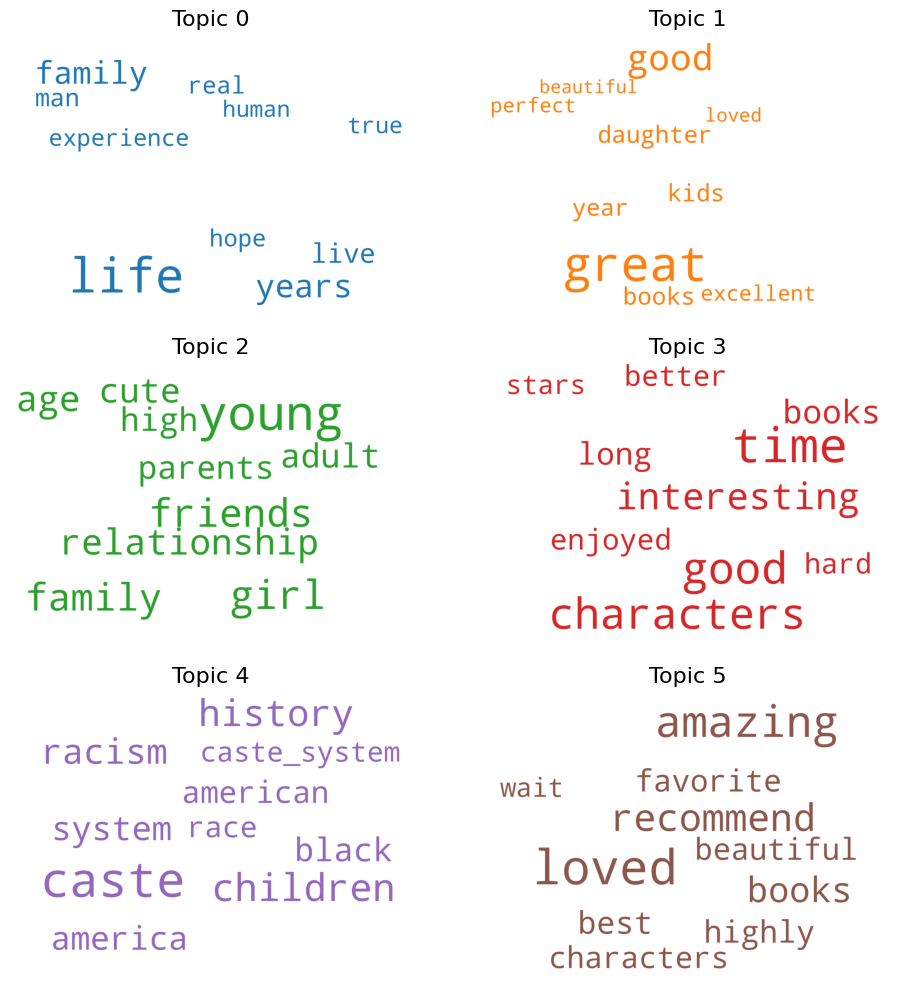

In [ ]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stoplist,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#### Word Score Bar Graph (with Word Count)

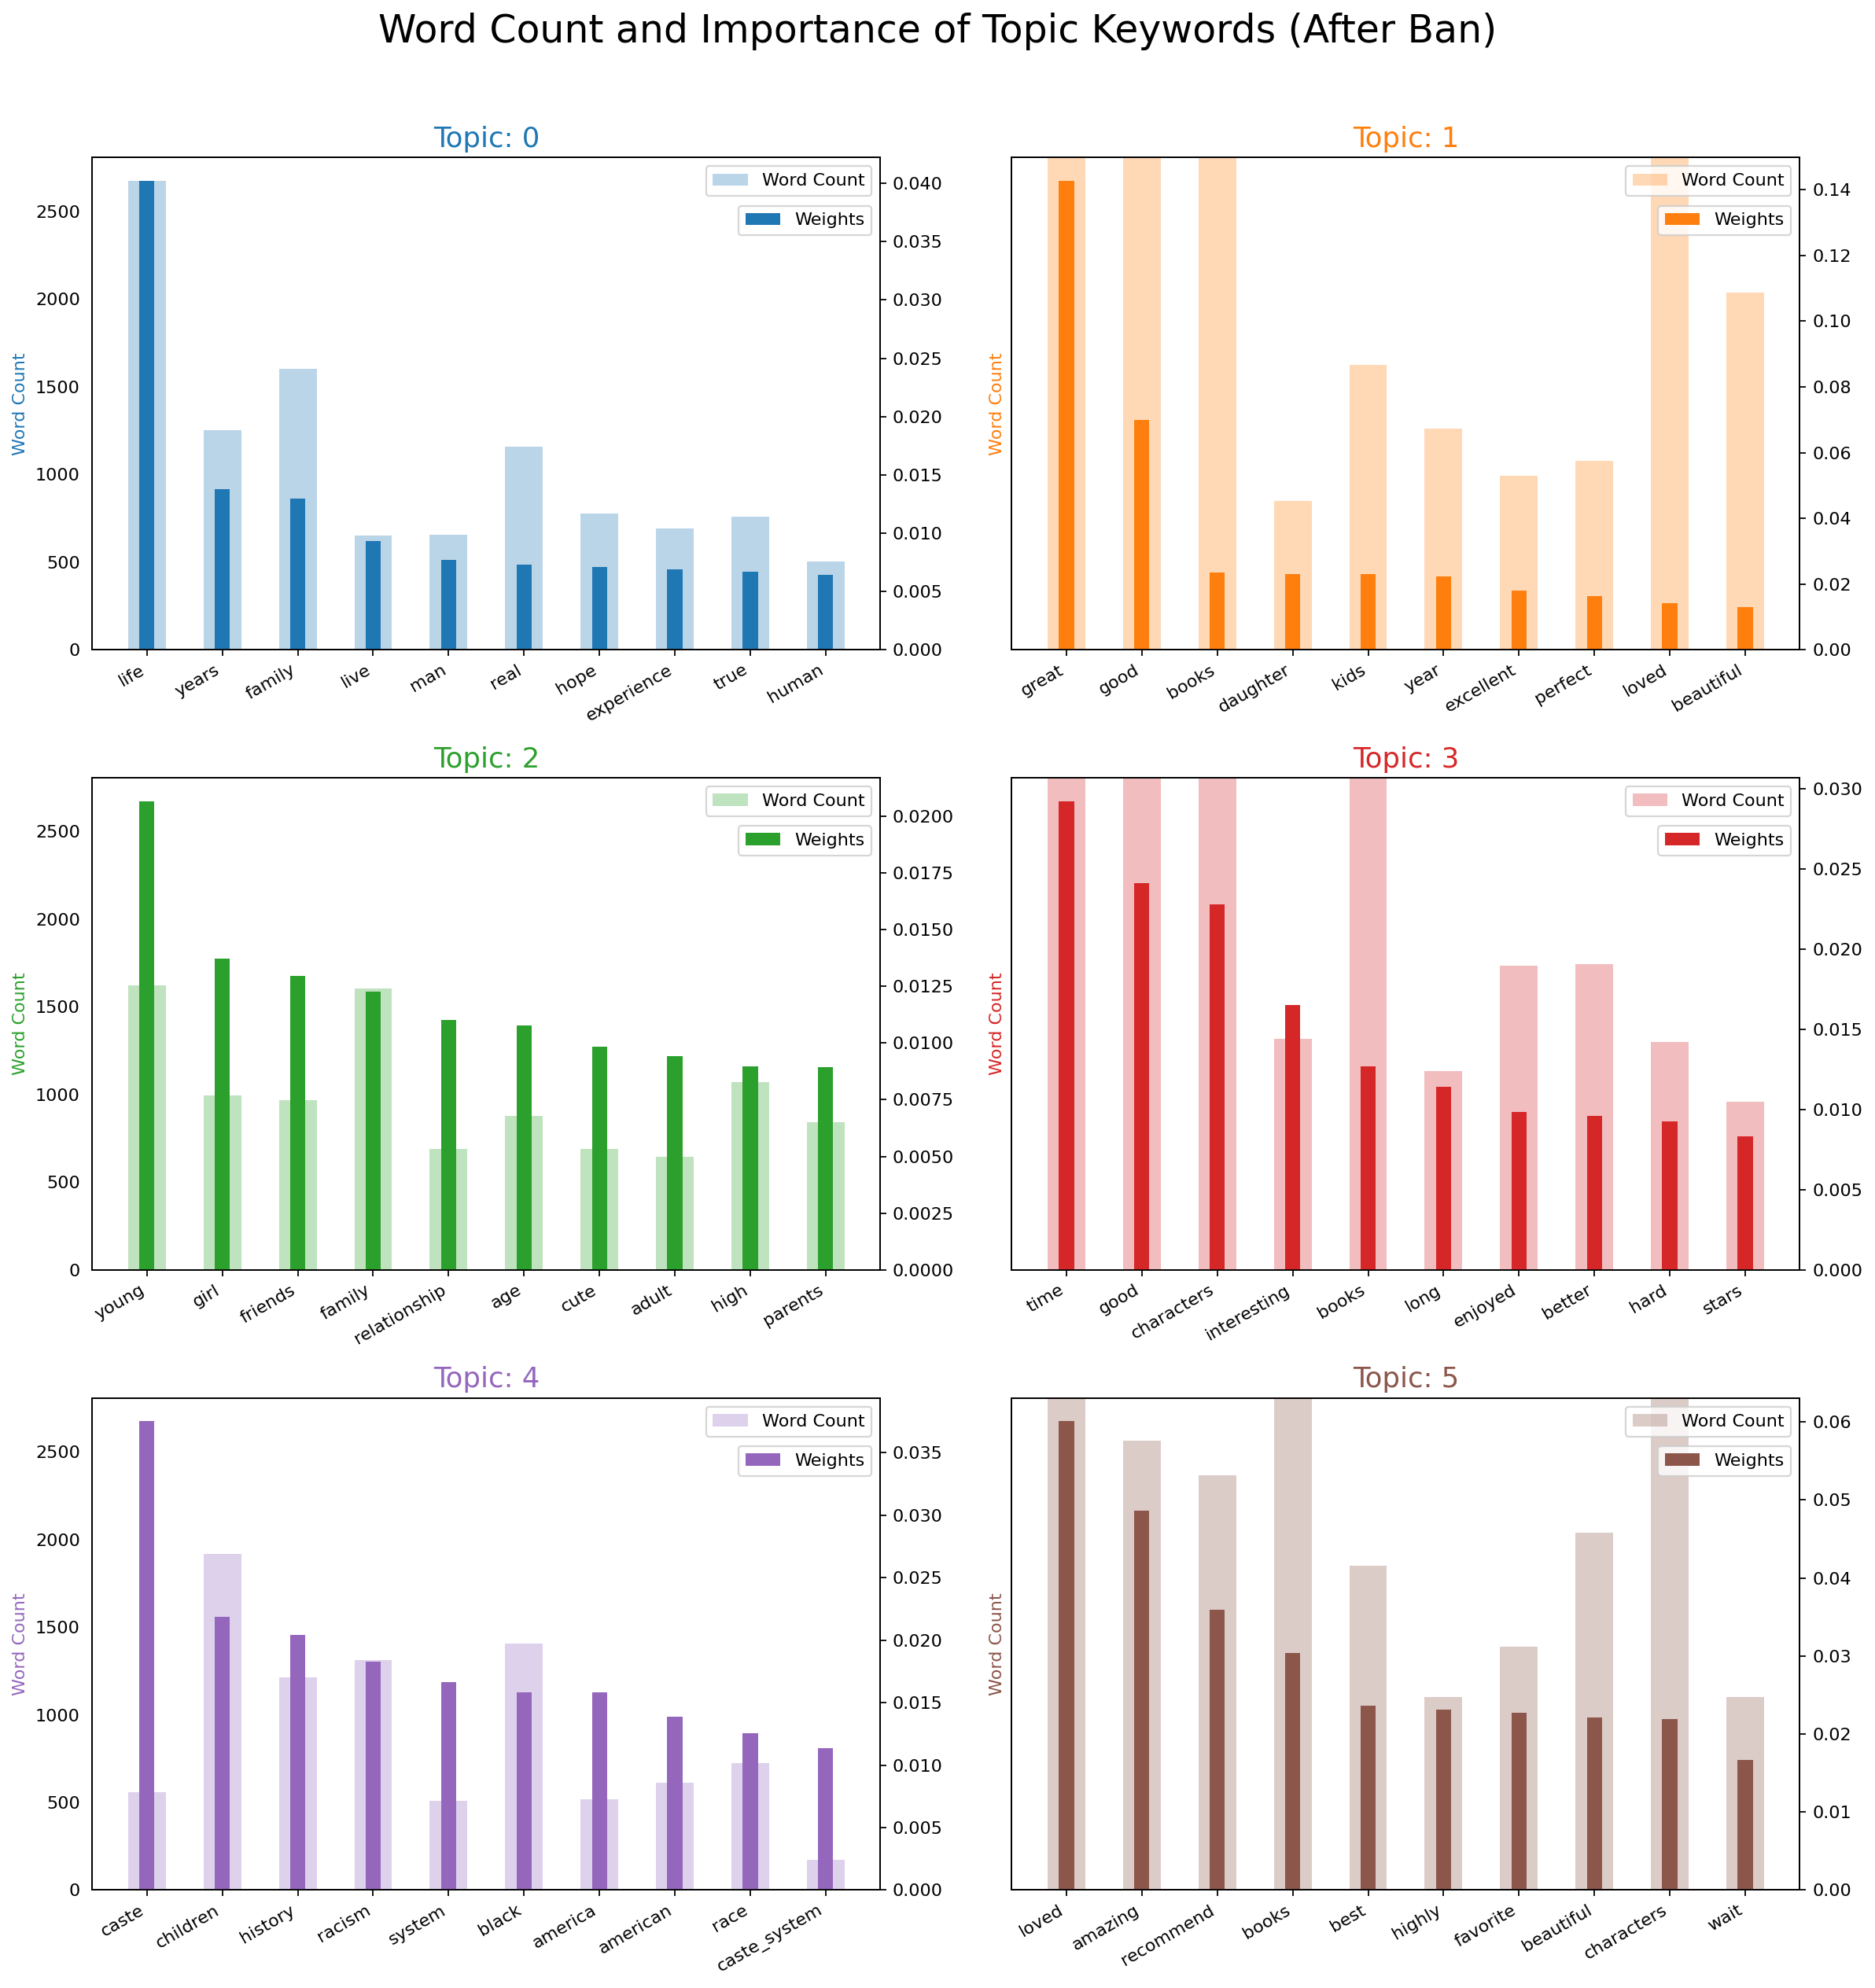

In [ ]:
topics = lda_model.show_topics(formatted=False)

data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(15,15), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, None); ax.set_ylim(0, None)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper right'); ax_twin.legend(bbox_to_anchor=(1.0, .92))

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords (After Ban)', fontsize=22, y=1.05)    
plt.show()

### Show the Model's Final Perplexity and Coherence Scores

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 


Perplexity:  -6.95593430714717


In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, corpus=corpus, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ',  coherence_lda)


Coherence Score:  0.5329147848395596
